In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob

In [4]:
main_path = 'gdrive/My Drive/luna/'
working_path = 'gdrive/My Drive/luna/output/'

on image gdrive/My Drive/luna/output/masks_0022_0348.npy


TypeError: ignored

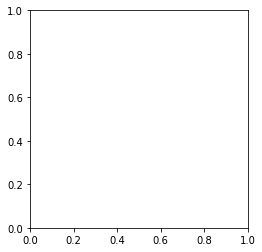

In [12]:
one_img = 'masks_0022_0348.npy'
#one_img = 'images_0011_0129.npy'
image=working_path + one_img
imgs_to_process = np.load(image).astype(np.uint8) 
print ("on image", image)
plt.imshow(image)


[[-5.60789159e+31 -5.60789159e+31 -5.60789159e+31 ... -5.60789159e+31
  -5.60789159e+31 -5.60789159e+31]
 [-5.60789159e+31 -5.60789159e+31 -5.60789159e+31 ... -5.60789159e+31
  -5.60789159e+31 -5.60789159e+31]
 [-5.60789159e+31 -5.60789159e+31 -5.60789159e+31 ... -5.60789159e+31
  -5.60789159e+31 -5.60789159e+31]
 ...
 [-5.60789159e+31 -5.60789159e+31 -5.60789159e+31 ... -5.60789159e+31
  -5.60789159e+31 -5.60789159e+31]
 [-5.60789159e+31 -5.60789159e+31 -5.60789159e+31 ... -5.60789159e+31
  -5.60789159e+31 -5.60789159e+31]
 [-5.60789159e+31 -5.60789159e+31 -5.60789159e+31 ... -5.60789159e+31
  -5.60789159e+31 -5.60789159e+31]]


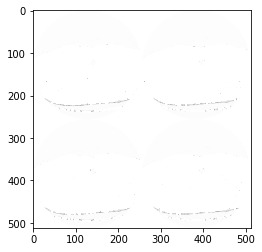

In [ ]:
img = imgs_to_process[0]
print(img)
plt.imshow(img,cmap='gray')
#Standardize the pixel values
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
#plt.hist(img.flatten(),bins=200)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


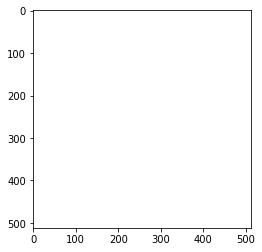

In [ ]:
plt.imshow(img,cmap='gray')

## We have to make sure that we set our threshold between the lung pixel values and the denser tissue pixel values.

In [ ]:
middle = img[100:400,100:400] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
#move the underflow bins
img[img==max]=mean
img[img==min]=mean

kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1])) #n_clusters changes the image
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

plt.imshow(thresh_img,cmap='gray')

ValueError: ignored

# apply erosion and dilation

In [ ]:
eroded = morphology.erosion(thresh_img,np.ones([4,4]))
dilation = morphology.dilation(eroded,np.ones([10,10]))
labels = measure.label(dilation)
label_vals = np.unique(labels)
plt.imshow(labels, cmap='gray')

NameError: ignored

## lungs are generally far away from the top and bottom of the image, so any regions that are too close to the top and bottom are removed

In [ ]:
labels = measure.label(dilation)
label_vals = np.unique(labels)
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    #if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472: #change the constant values
    if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>100 and B[2]<472:
        good_labels.append(prop.label)
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0

#  do another large dilation
#  in order to fill in and out the lung mask 
#
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
plt.imshow(mask,cmap='gray')

NameError: ignored

# Applying the masks and cropping and resizing the image
applying the mask of the lung ROI to each of the images, cropping down to the bounding square of the lungs ROI, and then resizing the resulting image to 512 X 512.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:489: RuntimeWarning: overflow encountered in add
  A_resampled += a_min


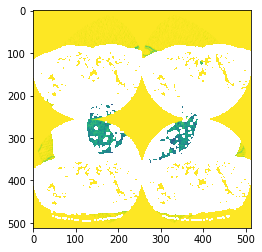

In [ ]:
sample_img = working_path+one_img

sample_mask = working_path + 'masks_0011_0129.npy'
masks = np.load(sample_mask)
imgs = np.load(sample_img)
imgs = masks*imgs
plt.imshow(imgs[0,:,:]) #rupa's addition

## renormalizing the masked image (in the mask region)

In [ ]:
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pushing the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std
plt.imshow(img,cmap='gray')

NameError: ignored

## Writing out images and masks as 1 channel to feed into unet
### to run below code, need to loop every image (check out in .py file)

In [ ]:
# make image bounding box  (min row, min col, max row, max col)
out_images = []  # final set of images
out_nodemasks = []  # final set of nodemasks
labels = measure.label(mask)
regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
min_row = 512
max_row = 0
min_col = 512
max_col = 0
for prop in regions:
    B = prop.bbox
    if min_row > B[0]:
      min_row = B[0]
    if min_col > B[1]:
      min_col = B[1]
    if max_row < B[2]:
       max_row = B[2]
    if max_col < B[3]:
       max_col = B[3]
width = max_col - min_col
height = max_row - min_row
if width > height:
    max_row = min_row + width
else:
    max_col = min_col + height
        #
        # cropping the image down to the bounding box for all regions
        #
    img = img[min_row:max_row, min_col:max_col]
    mask = mask[min_row:max_row, min_col:max_col]
if max_row - min_row < 5 or max_col - min_col < 5:  # skipping all images with no god regions
    pass
else:
            # moving range to -1 to 1 to accomodate the resize function
    mean = np.mean(img)
    img = img - mean
    min = np.min(img)
    max = np.max(img)
    img = img / (max - min)
    new_img = resize(img, [512, 512])
    new_node_mask = resize(mask[min_row:max_row, min_col:max_col], [512, 512])
    out_images.append(new_img)
    out_nodemasks.append(new_node_mask)

num_images = len(out_images)
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
val_i = int(0.1*num_images)

np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])

np.save(working_path+"valImages.npy",final_images[rand_i[val_i:test_i]])
np.save(working_path+"valMasks.npy",final_masks[rand_i[val_i:test_i]])

np.save(working_path+"testImages.npy",final_images[rand_i[:val_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:val_i]])

NameError: ignored

# check roi isolating

image 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:468: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:489: RuntimeWarning: overflow encountered in add
  A_resampled += a_min


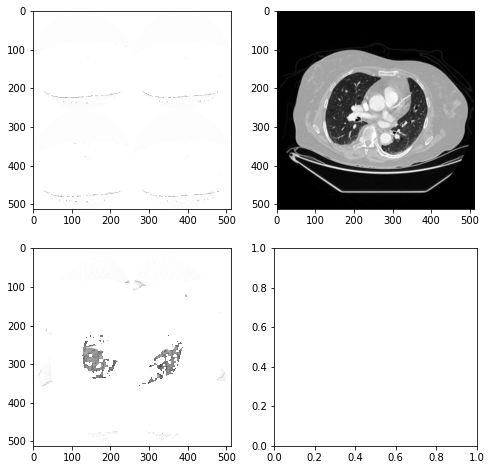

image 1


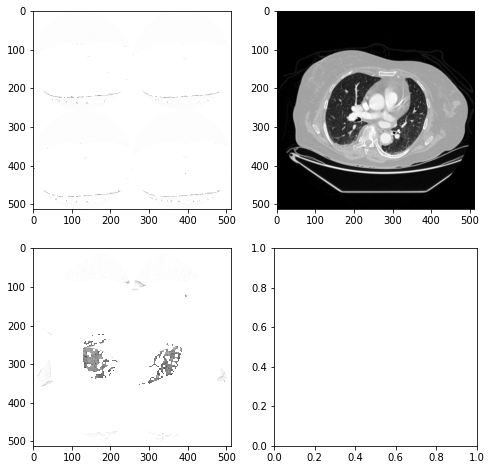

image 2


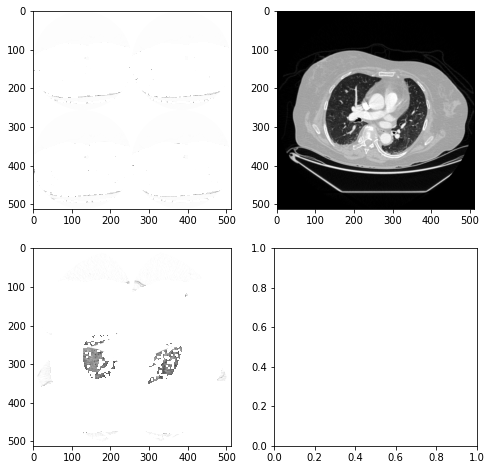

In [ ]:
imgs = np.load(sample_img)
lungmask = np.load(sample_mask)

for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    

    plt.show()